# COGS 118A - Final Project

# Insert title here

## Group members

- Raam Chaklashiya
- Vinay Pillai
- Juan Villalobos
- Kavya Balaji


# Abstract 

Diabetes is a chronic health condition which affects approximately 422 million adults worldwide, with the majority of those affected living in low\-income or underdeveloped countries. The timely diagnosis and treatment of diabetes can be crucial to patient health; access to insulin and health monitoring can be the difference between life and death. Our project aims to develop a binary classifier for diabetes based on the Diabetes Prediction Dataset from Kaggle; it provides multiple variables such as age, smoking history, blood measurements, and the presence of related conditions like hypertension and heart disease, of which we will be identifying the most significant features that contribute to diabetes. In this project, we began with a basic random forest classifier using default parameters, and optimized our hyperparameters using a halving grid search. Our final model is recall\-scored, with a recall of 70.6%. In context, this means we are identifying 70.6% of diabetic patients. Notably, we identified possible areas for bias in our data, which may be skewing final results.


# Background

Diabetes is a chronic, metabolic disease which has the potential to cause serious organ damage to the heart, blood vessels, eyes, and more. Type 2 diabetes is most common in adults, which we have seen rising prevalence of in recent years. Type 2 diabetes occurs when the body becomes resistant to insulin, and Type 1 diabetes occurs when the body does not produce enough insulin[\[1\]](#lorenznote). Both forms of diabetes require timely diagnosis and treatment, which is why building models to potentially identify diabetes based on various metrics is an important and necessary pursuit. In doing so, we may be able to diagnose individuals who carry markers or fit trends earlier than before.

Currently, identifying diabetes has to do with symptoms, not markers for disease. Type 1 diabetes can cause nausea, vomiting, or stomach pains; however, symptoms of Type 2 diabetes can take years to develop, and may never[\[2\]](#admonishnote)! So, predicting the disease without seeing symptoms has the potential to save lives. Progress has been made in terms of using machine learning to identify diabetes and other forms of disease. Logistic regression, random forest, a developed ensemble model, and SVM were all methods considered in a study by BMC Medical [\[3\]](#admonishnote). The developed ensemble model received an AU\-ROC score of 73.7, which was the best performance without laboratory data. Similar studies have been conducted by the NIH and BioMed Central, showing that there is sure progress to be made in this realm. 

# Problem Statement

We aim to identify relevant risk factors associated with diabetes and predict whether or not a patient has diabetes based on health factors such as age, related medical conditions such as hypertension and heart disease, and blood measurements.

# Data

The dataset we will be using to accomplish our project is the [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) from Kaggle, sourced from the Electronic Health Records \(EHRs\). It contains 100,000 observations of 9 variables. An observation consists of one entry of each of the following nine variables: gender, age, hypertension, heart disease, smoking history, BMI, HbA1c level \(Hemoglobin A1c\), blood glucose level, and diabetes. Some of the critical variables are hypertension, heart disease, and diabetes, which are represented by a 0 or 1 to indicate the presence of the condition. Additionally, smoking history, BMI, HbA1c level, and blood glucose level are critical since they are common risk factors for diabetes. Smoking history is represented by one of 6 categories which we will use one\-hot encoding to represent: not current, former, no info, current, never, and ever. We will filter out the observations with no info of smoking history to provide our model with more consistent data which will leave us with around 64,000 observations. BMI and HbA1c level are represented as whole number or decimal value, while blood glucose level is represented entirely by whole numbers.

In [66]:
import pandas as pd
import numpy as np

# import and view data

data = pd.read_csv("diabetes_prediction_dataset.csv")
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


After importing our data, we first removed all data points that didn't have smoking history information and simplified the gender category to only include males and females as to not throw off our model since there were only 12  "Other" observations which left us with 64,172 data points. We then one-hot encoded the smoking history categories so that we could use them as predictors for our model which will represent the 5 levels: current, ever, former, never, and not current, with a 1 indicating the smoking status and 0s in the other 4 positions for a given observation. 

In [67]:
# remove data with no smoking history information
data = data[data.get("smoking_history") != "No Info"]
# remove 12 observations to simplify to binary categories
data = data[data.get("gender") != "Other"]
# one-hot encode the smoking history
one_hot = pd.get_dummies(data["smoking_history"])
one_hot.head()

,current,ever,former,never,not current
0,False,False,False,True,False
2,False,False,False,True,False
3,True,False,False,False,False
4,True,False,False,False,False
5,False,False,False,True,False


Next, we dropped the old smoking history column and joined our dataframe with the one\-hot encoding. We then used a label-encoder to encode the `gender` variable as a 0 for female and 1 for male. We create a new dataframe for the cleaned data so that we can explore the data without the one-hot encoding in our EDA. Lastly, we stored our predictors in a variable called `X` and our diabetes label in a variable called `y_true` to use in our models. 

In [72]:
# remove the old smoking history column and add in the one-hot encoded smoking history
cleaned_data = data.drop('smoking_history',axis = 1)
cleaned_data = cleaned_data.join(one_hot)

# encode gender predictor, one-hot not necessary since there's only two values
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cleaned_data['gender'] = encoder.fit_transform(cleaned_data['gender'])

# ground truth labels
y_true = cleaned_data["diabetes"]

# separate predictors from label
X = cleaned_data.drop(columns=["diabetes"])
X

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,current,ever,former,never,not current
0,0,80.0,0,1,25.19,6.6,140,False,False,False,True,False
2,1,28.0,0,0,27.32,5.7,158,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,True,False,False,False,False
5,0,20.0,0,0,27.32,6.6,85,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99992,0,26.0,0,0,34.34,6.5,160,False,False,False,True,False
99993,0,40.0,0,0,40.69,3.5,155,False,False,False,True,False
99997,1,66.0,0,0,27.83,5.7,155,False,False,True,False,False
99998,0,24.0,0,0,35.42,4.0,100,False,False,False,True,False


This leaves us with 64,172 observations of 13 variables in our cleaned data, 12 of which we will use as predictors to predict the 13th variable: the presence of diabetes. 

# Proposed Solution

Since we are working on a binary classification task \(whether or not a patient has diabetes\), a reasonable classifier to use is a random forest, which has numerous advantages in the context of our dataset. Random forests are fast to train even on large datasets like ours and still retain good performance. They also can give an estimate as to which features are more significant in classification via permutation, which is important to know since we are trying to identify the most significant risk factors of diabetes. Furthermore, by the nature of using decision trees for classification, we won't have to scale our variables to match each other which could have been a concern since HbA1c level is on a much lower scale than blood glucose level and BMI. 

We will use a train/validation/test split to test our model since we have an abundance of data. After initially training the random forest, we will use grid search to find the best hyperparameters for our model. Finally, we will test our model on the test set and evaluate its performance using its recall and F1-scores. 

# Evaluation Metrics

A valid evaluation metric for our problem would be recall, which is defined as the number of true positives divided by the number of true positives \+ false negatives. We are most concerned with correctly identifying the presence of diabetes \(true positive\) and minimizing the number of times our model incorrectly identifies a patient with diabetes as not having diabetes \(false negative\), which is exactly what recall measures. However, it is also important to consider false positives, since theoretically a model could simply predict all patients as having diabetes and this would maximize recall but would have an over\-abundance of false positives. For this reason, we will also be looking at the F1\-score of our model as it takes into account precision and recall and gives us an idea of the overall accuracy of our model. Precision is defined as the number of true positives divided by the number of true positives \+ false positives and F1\-score is: $\dfrac{2\times Precision \times Recall}{Precision+Recall}$ .

# Results 

### Exploratory Data Analysis

We were interested in the distribution of diabetic vs non-diabetic in our data and found that it was a 7,046 to 57,126 ratio which meant 11% of the observations in our data were diabetic. 

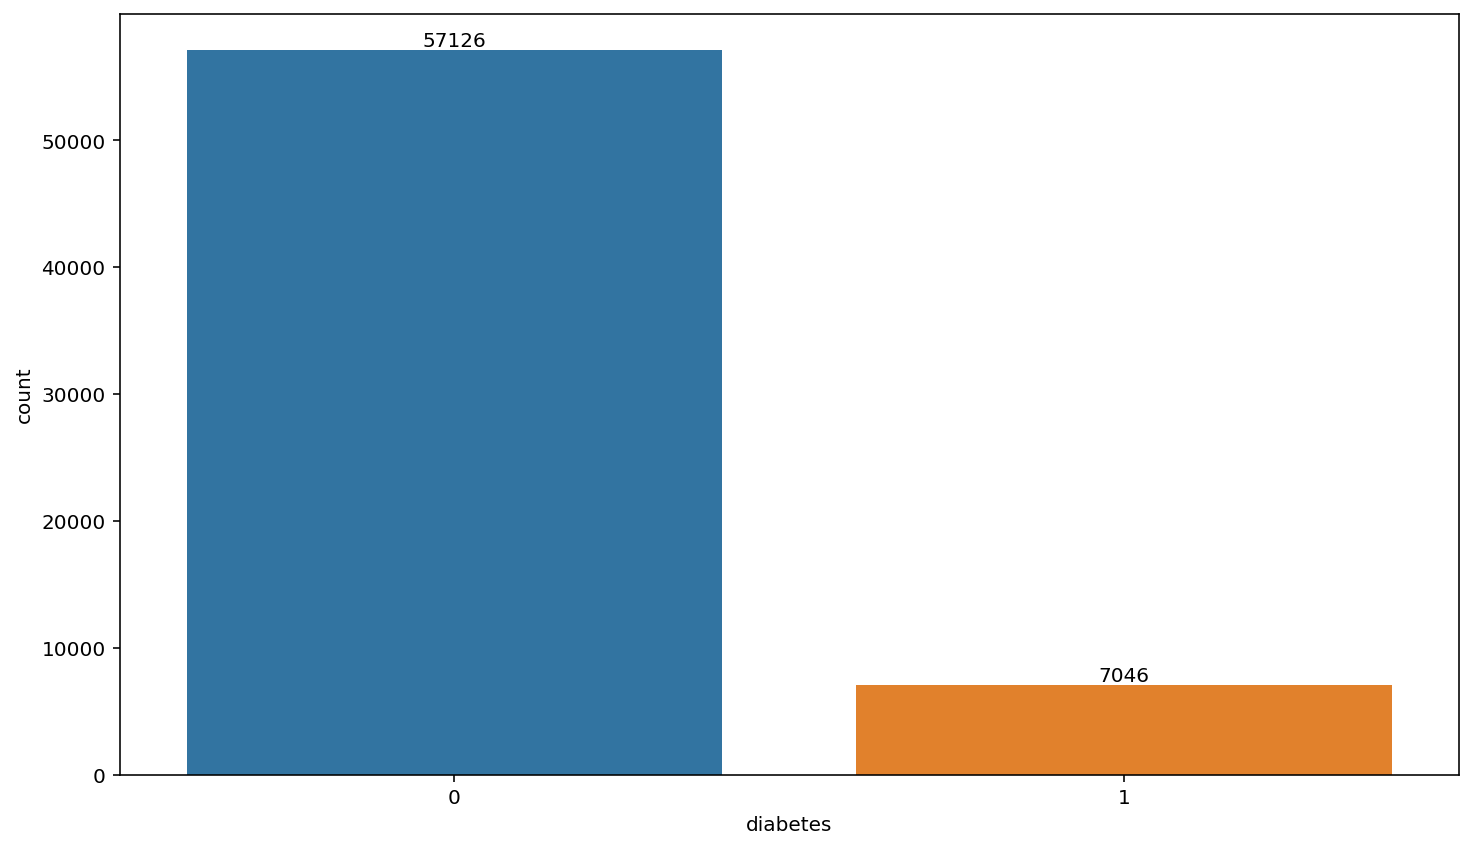

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# distribution of non-diabetic vs diabetic
ax = sns.countplot(x = "diabetes", data=data)
ax.bar_label(ax.containers[0]);

Next, we looked at the distribution of the ages in our data. We can see that on average, there are less individuals under the age of 19 and over the age of 62 than the ages in between. However, there is a large outlier in our data, that being the fact that there are 3,822 observations of age 80. This is likely a result of how the original data was obtained.

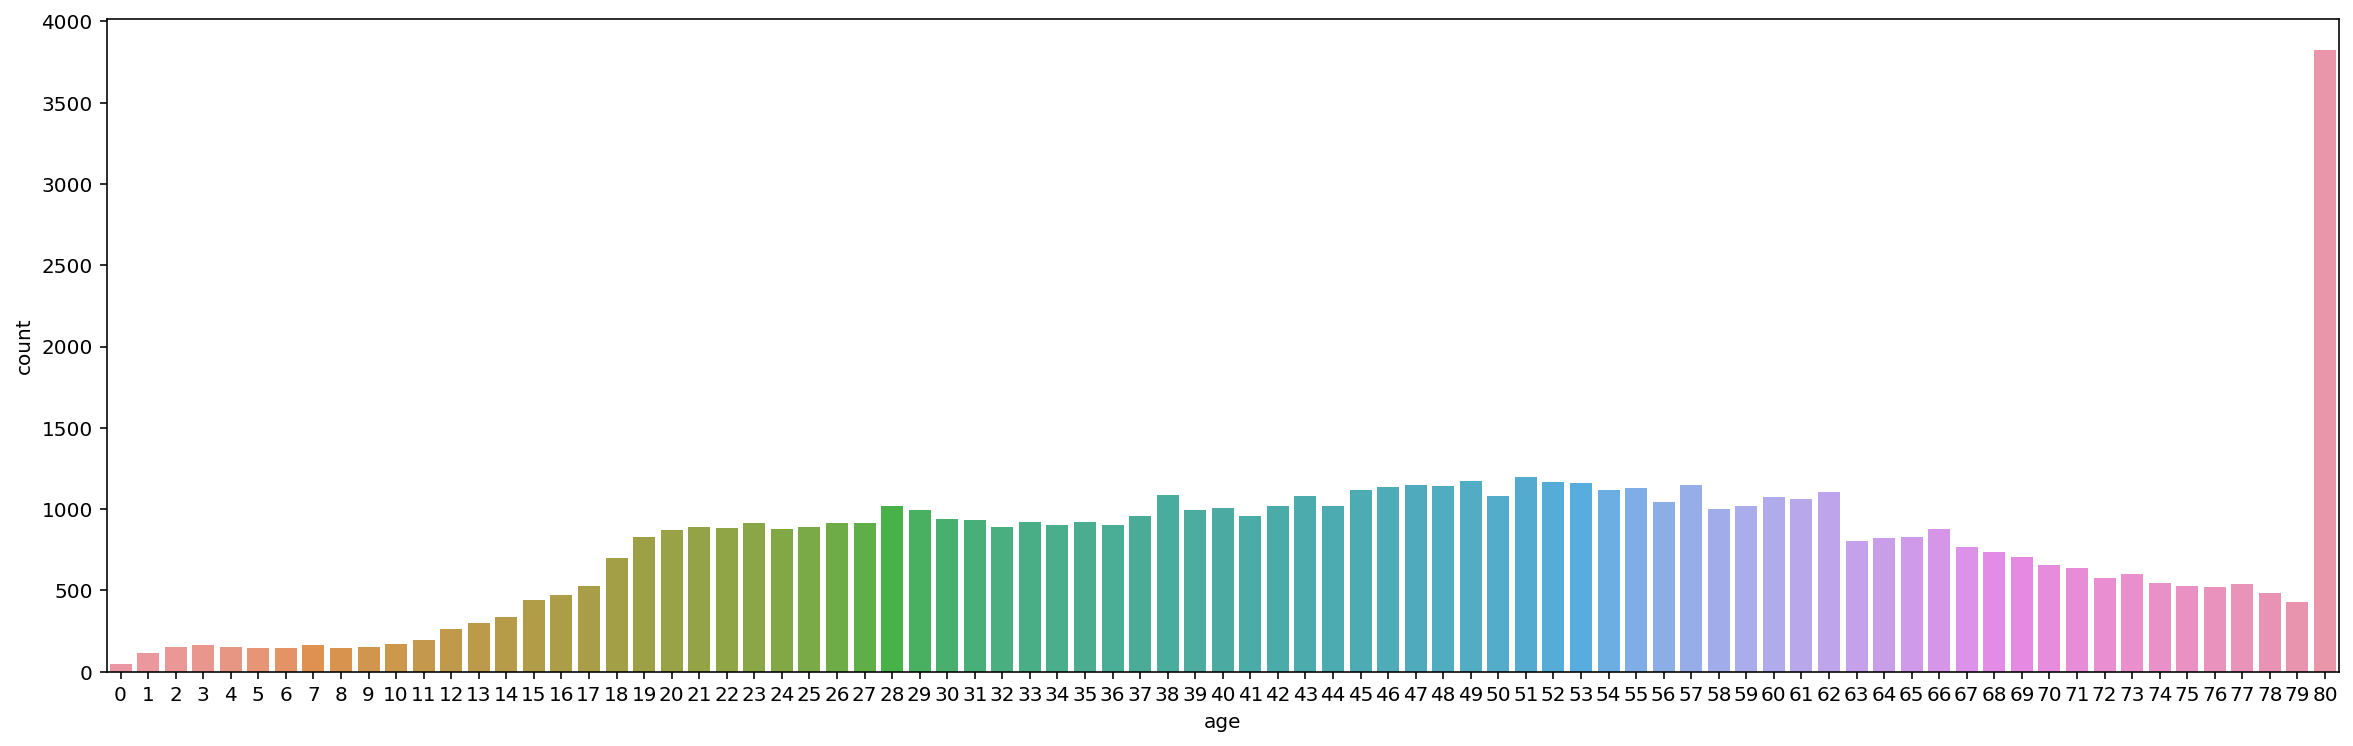

In [102]:
# set dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 6))
 
# plot age distribution, convert age to integers so x-axis labels are readable
sns.countplot(x=data.get("age").apply(int), ax=ax)
plt.show()

In [103]:
# checking the counts of the top 5 and bottom 5 ages
data.get("age").value_counts()

age
80.00    3822
51.00    1198
49.00    1172
52.00    1167
53.00    1163
         ... 
0.48        4
1.00        4
0.64        3
0.16        3
0.56        2
Name: count, Length: 101, dtype: int64

The distribution of gender in our data was unbalanced, with there being 38,852 females and 25,320 males. This meant our data was 39.5% males and 60.5% females.

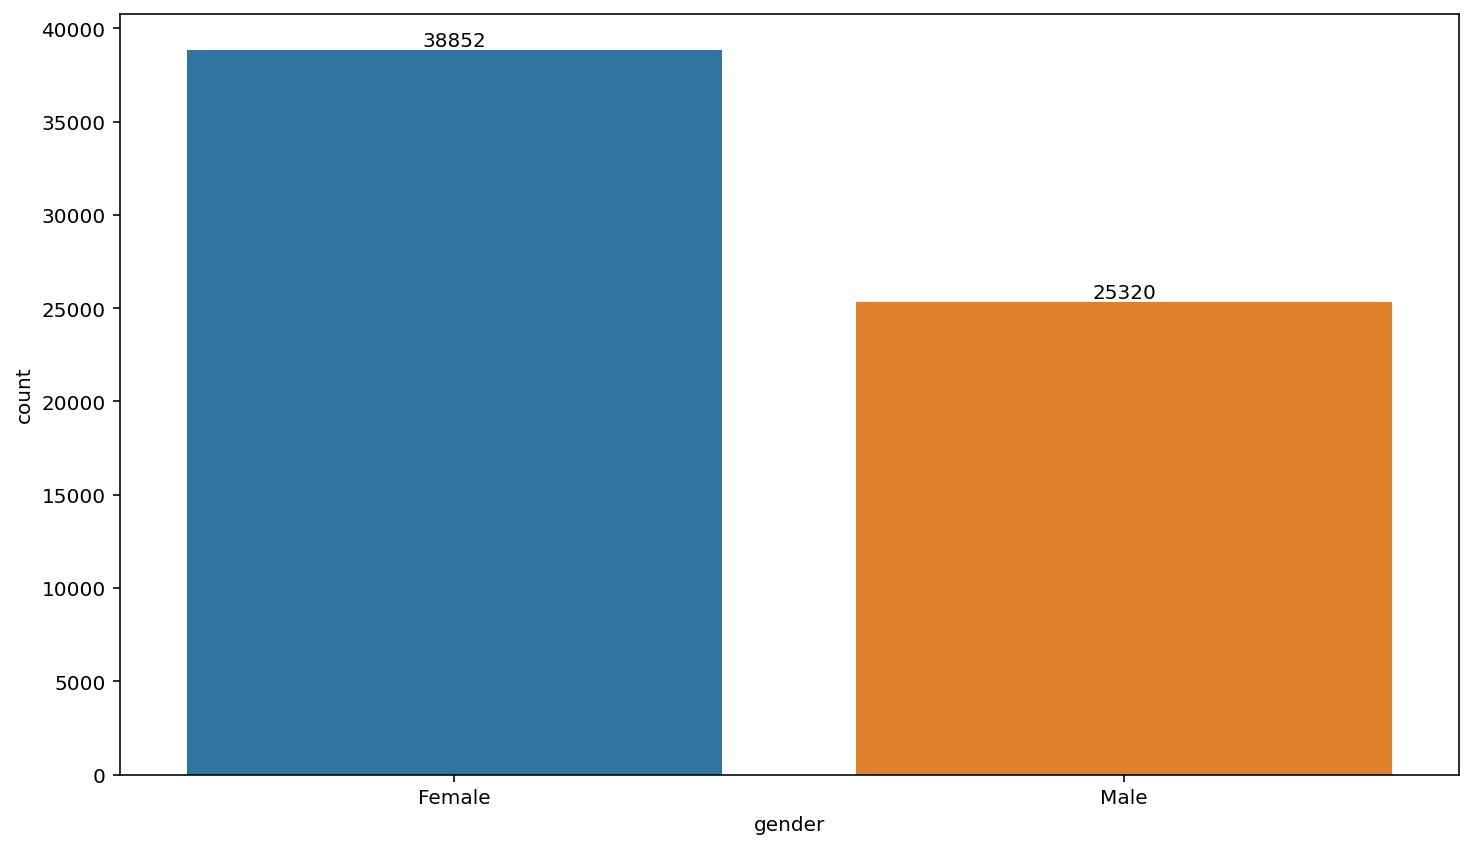

In [75]:
# distribution of male vs female
ax = sns.countplot(x = "gender", data=data)
ax.bar_label(ax.containers[0]);

Below is the distribution of the 5 levels for the smoking history category. We can see that the most dominant category is never smokers, with current and former smokers with very similar counts. 54.7% of patients in our data have never smoked before and 45.3% have smoked, which is a relatively even distribution.

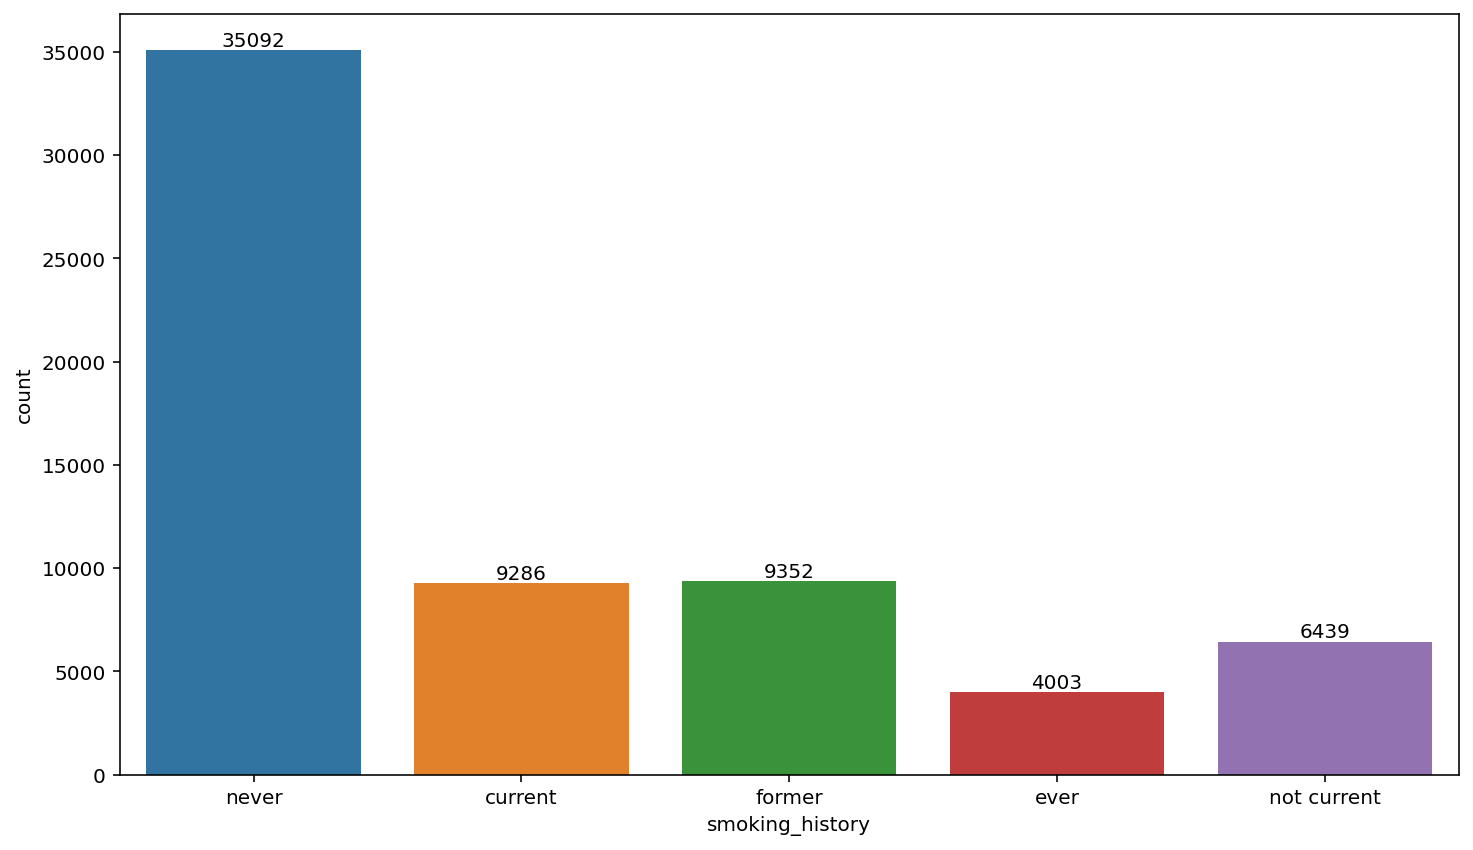

In [80]:
ax = sns.countplot(x = "smoking_history", data=data)
ax.bar_label(ax.containers[0]);

For the following two plots of hypertension and heart disease, we can see that those with the medical conditions are in the minority and hypertension is twice as prevalent than heart disease in our data.

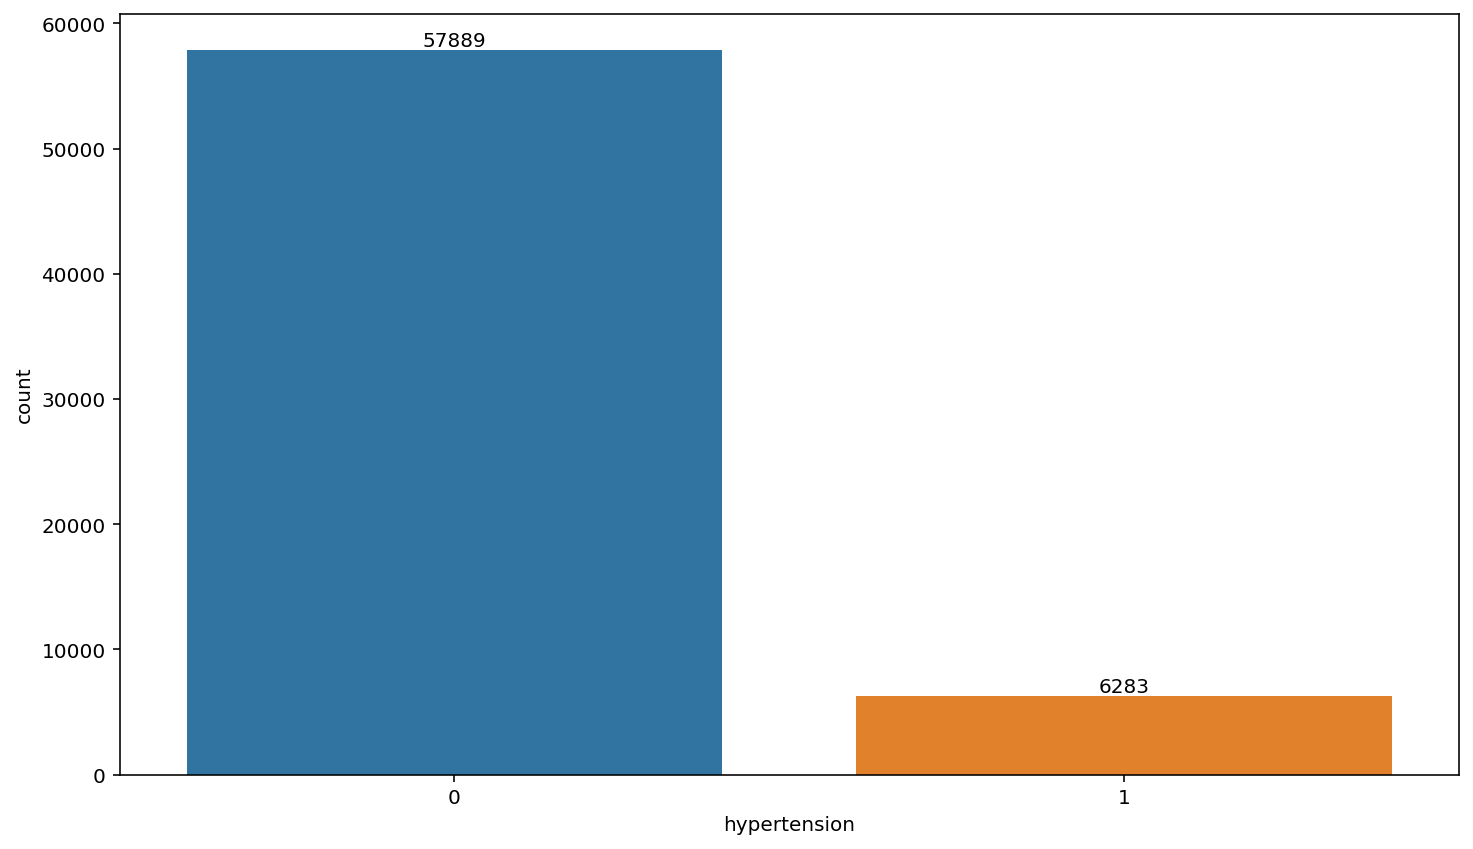

In [88]:
# hypertension distribution
ax = sns.countplot(x = "hypertension", data=data)
ax.bar_label(ax.containers[0]);

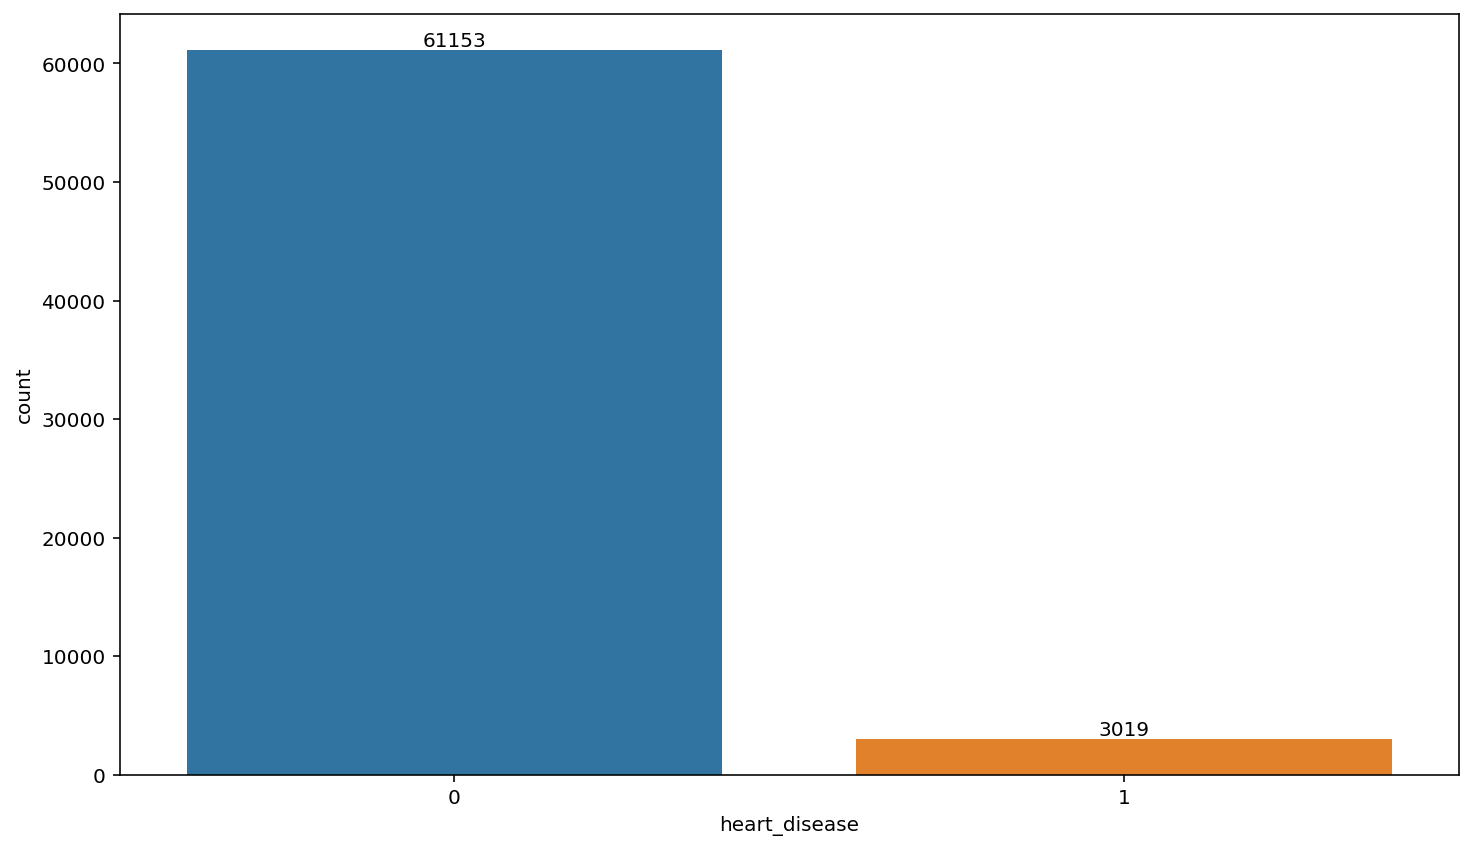

In [83]:
# heart disease distribution
ax = sns.countplot(x = "heart_disease", data=data)
ax.bar_label(ax.containers[0]);

### Initial Model

We started our analysis by training a basic random forest model on all of the predictors in our cleaned data with the default parameters to get familiar with the algorithm and get a benchmark performance from which we can try to improve. The sklearn `RandomForestClassifier` has the following default parameters we believe to be most relevant and that we will later be finding the optimal parameters for in our gridsearch:

- `n_estimators=100`: 100 trees as estimators
- `criterion=gini`: gini impurity as the split quality criterion
- `max_depth=None`: no maximum depth for the trees
- `min_samples_split=2`: a minimum of 2 samples required for an internal node to split
- `min_samples_leaf=1`: a minimum of 1 sample required to be a leaf node

Using a 75/25 train/test split of our cleaned predictors to fit the default random forest model, we obtained the following confusion matrix. We specify a `random_state` so that our results are consistent and easily reproducible.

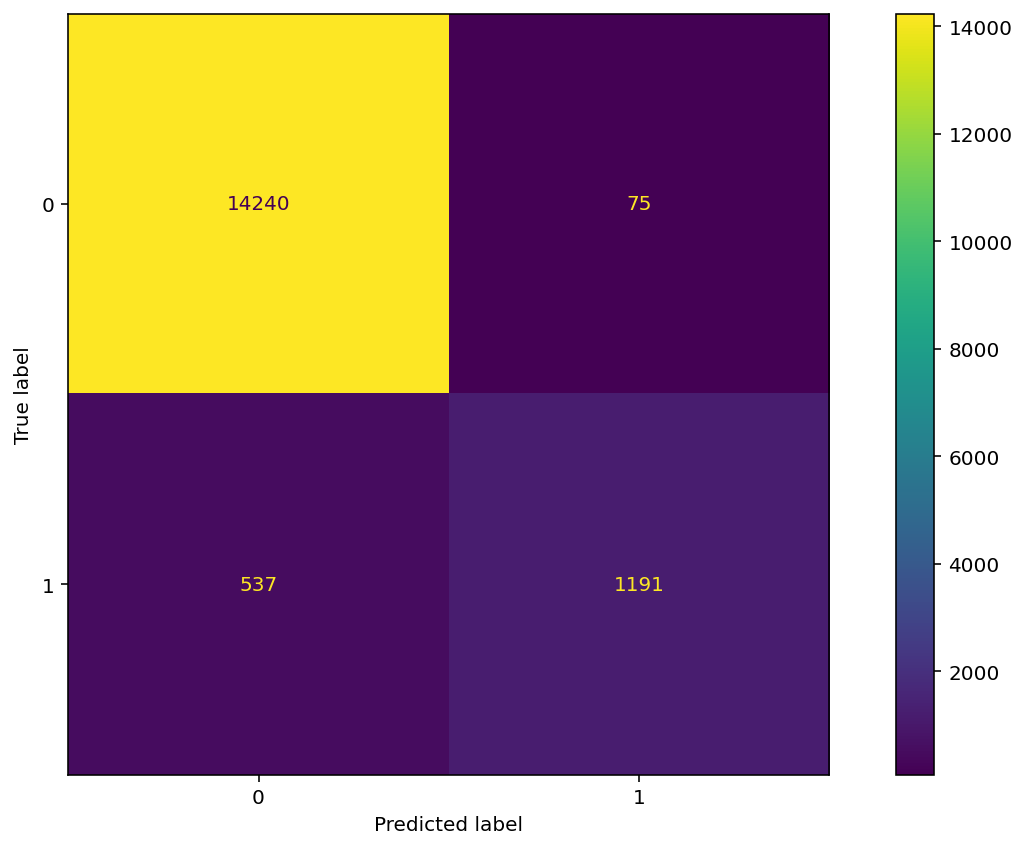

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, ConfusionMatrixDisplay

# split the data for the default random forest with a 75% training 25% testing split
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.25, random_state=1)

# train a default random forest classifier
base_model = RandomForestClassifier(random_state=1)
base_model.fit(X_train, y_train)

# get predictions and plot the confusion matrix for the base model
y_predict = base_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [78]:
# get the recall and F1-score for the base model
print("Recall Score: {}, F1-Score: {}".format(recall_score(y_test, y_predict), f1_score(y_test, y_predict)))

Recall Score: 0.6892361111111112, F1-Score: 0.7955911823647295


From the confusion matrix above, we can see that the model has a specificity of $\frac{14240}{14240+75}=99.5\%$, a recall of $\frac{1191}{1191+537}=68.9\%$, and a precision of $\frac{1191}{1191+75}=94\%$. The F1\-score for this model was 79.6% but we would like to improve the recall while still maintaining a high level of overall accuracy/F1\-score in our next models.

### HalvingGridSearch Cross-Validation

After setting up our base RandomForests model, we used HalvingGridSearchCV to optimize our hyperparameters. HalvingGridSearchCV differs from regular GridSearchCV in that it train the models on smaller subsets of the overall training set first in order to filter out the parameter choices that don't look promising. We tested the following sets of hyperparameters:

- n\_estimators: \[5,10,25,50,75,100\]
- criterion': \['gini', 'entropy', 'log\_loss'\]
- max\_depth: \[1, 2, 4, 5,10,15,20,25\] 
- min\_samples\_split: \[2,4,8,16,32,64\]
- min\_samples\_leaf: \[1,2,4,8,16,32\]

Most of these hyper parameters \(max\_depth, min\_samples\_split, min\_samples\_leaf, etc\) will impact how regularized our model is, and thus how well it will handle new data. The final set of selected parameters was as follows:

<img src="imgs/6.png"  alt="optimal params"  width="1229.22px"  height="164.609px"  style="object-fit:cover"/>

![confusion matrix](imgs/7.png)

From the confusion matrix above, we can see that this model's specificity is $\frac{14123}{14123+192}=98.7\%$, the recall is $\frac{1220}{1220+508}=70.6\%$ and the precision of this model is $\frac{1220}{1220+192}=86.4\%$. The F1\-score for this model was $\frac{2 * 0.864 * 0.706} {0.864 + 0.706} = 77.7%$%.


### F1-Scoring Criteria

In addition to our recall\-scored model, we also optimized a model using F1\-score as the scoring criteria. Similar to before, we used HalvingGridSearchCV to optimize the model, but we added 30 to the max-depth search space in order to allow the model to test slightly deeper trees, resulting in this final set of hyperparameters: 

![hyperparams](imgs/8.png)

This model is substantially different from the recall scored model, trading more estimators and deeper trees for a larger min\_samples\_split value.
<img src="imgs/9.png"  alt="confusion matrix"  width="1064px"  height="846px"  style="object-fit:cover"/>

From the confusion matrix above, we can see that this model has a specificity of $\frac{14224}{14224+43}=99.6\%$, a recall of  $\frac{1192}{1192+567}=67.7\%$ , a precision of  $\frac{1192}{1192+43}=96.5\%$ and a f\-score of$\frac{2 * 0.965 * 0.677} {0.965 + 0.677} = 79.5%$%.


# Discussion

### Interpreting The Results


#### EDA

From exploring our data, we found that the data was unbalanced in terms of the distributions of most of the predictors. They either had a large majority of one group or a large outlier in the distribution. 11% of the observations were diabetic and 89% were non-diabetic indicating that models trained on this data would be biased towards predicting a given observation as being non-diabetic. This is important for us to keep in mind since if our model is more biased towards predicting non-diabetic than it should be, it may be a reason why we end up with a lower recall. We found that there was a very large outlier for the age distribution at age 80, indicating a clear bias in the population the data way obtained from. It's especially strange that only age 80 had a clear majority rather than older ages in general, which could've been explained as a result of older individuals being of higher risk of diabetes/heart conditions and thus being a part of the dataset but that is not the case. The distribution of gender was 39.5% for male and 60.5% for female, which is not what you would expect from a sample of a general population, which would be closer to 50-50. The smoking history distribution was relatively reasonable at 54.7% non-smokers and 45.3% smokers. 

#### Initial Model

From our initial model, we found that the model tended to correctly classify true negatives very accurately, correctly classifying non\-diabetic patients as non\-diabetic 99.5% of the time. However, we are mainly concerned with recall which was 68.9% for the model, meaning we correctly classify diabetic patients as diabetic only 68.9% of the time, which isn't ideal. The 94% precision indicated that 94% of our model's diabetic predictions were correct. Putting these facts together, we can notice that the base model tends to miss a lot of patients who are diabetic and misclassify them as non\-diabetic rather than classifying non\-diabetics as diabetic. The F1\-score of 79.6% is a decent balance of precision and recall for an unoptimized model, however since we are more concerned with the recall of the model, we tried to improve it while still maintaining a high level of overall accuracy/F1\-score.

#### HalvingGridSearch Cross-Validation

Although some of the hyperparameters remained the same as the base model, the number of estimators dropped from 100 to 5 and the max depth of the decision trees was set at 25. These two changes prevent the model from overfitting the training data, relative to the base model. 

From the optimized model, we found that this model's specificity is slightly lower than that of the previous model at 98.7%. On the other hand, the recall was 70.6%, meaning we are less likely to miss true diabetic patients. The precision of this model is 86.4% meaning that this model is as a whole less accurate than the base model. However, since our goal is to maximize recall and therefore minimize the chance of missing true diabetic patients, this is a worthwhile tradeoff.  Finally, the F1\-score for this model was 77.7%, which is an expected drop since our precision has decreased compared to the previous model.

#### F1-Scoring Criteria

At 99.6% and 96.5%, the f1\-scored model's specificity and precision is actually higher than both the previous models. However, the recall for this model is the lowest so far, at 67.7%,  meaning we are more likely to miss true diabetic patients. This reduction in recall would make it more likely for diabetic patients to not be correctly diagnosed, making it an inferior model for our purposes.  Surprising, the F1\-score for this model was slightly lower than the base model at 79.5%, reflecting the precision\-recall tradeoff.


### Limitations

There are a number of limitations in our work that would likely be beneficial to explore in future work. From our EDA, we noticed a lot of the predictors were unbalanced in their distributions and there was a large outlier in the age distribution with 3,822 individuals of age 80, more than 2,000 more than the 2nd most common age. To handle the unbalanced nature of the data, we could reduce the amount of dominant class observations we use until we reach a suitable balance between the two classes. To handle large outliers, we could investigate how the model performs without the outlier or reduce the amount of observations from that category that we use in the model. 

Aside from the data, it could be good to explore more hyperparameters of the random forest itself, such as different scoring criteria/evaluation metrics during gridsearch. However, this comes at the cost of the gridsearch taking even longer, but if we do this in combination with reducing the amount of data we use, it could end up evening out more.

### Ethics & Privacy

When looking at data a major concern is the privacy of individuals: not allowing the public to be able to identify the person based on the information from this data.  Another concern would be that of consent: where the data that was collected was obtained forcefully from the patient. Our data was from Kaggle, where the person who obtained the data got it from various healthcare providers, such as hospitals and clinics. The patients allowed these healthcare providers to obtain this information from different tests. From these places they have a set of procedures that they need to follow in order for them to get consent form the patients. When it comes to the privacy of the individuals, the data that was collected do not have specific enough information to make an individual known to the public therefore we can safely say that their privacy is secured. 

Another aspect that can be of concern is that of collection bias: where the data that was collected from a specific set of individuals that may be prone to what we are investigating or not be prone to, based on the methods of the data collection. A way this has been overcome was through the methods of how the data was collected from different electronic health records from different hospitals and clinics, therefore minimizing the amount of data that was collected specifically from individuals that may be prone to what we are investigating or not be prone to. Therefore our predictions from this dataset should not be exposed from collection bias.

### Conclusion

The goal of our model was to reasonably predict diabetes based on certain relevant risk factors. In our initial model, we used default parameters, and we later optimized our hyperparameters using a halving grid search, which filters out less promising parameters. Our final model using these optimizations had less overfitting and higher recall than the base model. With a final recall of 70.6%, we looked into possible areas of bias in our data, and found that most predictors were drastically unbalanced, which could contribute to lower recall. We also tried an F1\-scored model, which was ruled out due to low recall. Thus, after multiple rounds of improvement, we are able to predict/identify diabetes in true diabetics 70.6% of the time. As previously mentioned, work has only begun on using machine learning to predict disease using markers in data; for diabetes specifically, there are a multitude of organizations working on using different risk factors and scoring criteria to identify diabetes. However, it is largely recognized that models have room for improvement, and there is a lot of benefit to be gained from improving our ability to accurately predict life\-changing diseases.


# Footnotes
1.[^](#lorenz)World Health Org. \[[https://www.who.int/health\-topics/diabetes\#tab=tab\_1](https://www.who.int/health-topics/diabetes#tab=tab_1) \]<br> 
2.[^C](#admonish)DC https://www.cdc.gov/diabetes/basics/symptoms.html <br>
3.[^BMC: ](#sota): [https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911\-019\-0918\-5](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-019-0918-5) 
